<h1><center>Stack Overflow</center></h1>
<h3><center>Insights into one of the leading sites for answering programming questions</center></h3>

If you've ever googled a programming question in the past, chances are you've been to and been helped by Stack Overflow!

This is a subset of the data available on Google BigQuery for free. This contains pretty much all the information about a post you could want:

- Title
- Entire contents of the post
- Number of answers, views, favorites
- Dates of creation, editing
- And much more!

### Imports

In [3]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import glob
import statsmodels.api as sm

from math import floor

from dfply import *

from collections import Counter

from sklearn import linear_model
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import random

import warnings
warnings.filterwarnings("ignore")

global_width = 14
global_height = 8

### Data Exploration / Feature Engineering

The way GoogleBigQuery works is that you can query their database using SQL commands and get a certain amount of free searches (measured by data returned). So over the course of a few months I downloaded 5,000 rows of information at a time. This **glob** command will combine all of them together into a single, large csv file.

In [31]:
df = pd.concat([pd.read_csv(f) for f in glob.glob('results-*.csv')], ignore_index = True)

There is a limit at the amount of data you're allowed to pull from Google Big Query each month so I settled for 195,000 rows of data from the entire Dataset which I imagine will be representative of the whole.

Below is an image of the interface for a more clear image of how this data was gathered.

![title](bigquery.png)

In [3]:
df = pd.read_csv('py_r.csv')

Some basic feature engineering to get some more possible features to predict values from.

In [33]:
# A boolean value of whether or not there's an answer to the question
df['answer'] = df['answer_count'] > 0
# An 'accepted_answer' is one where the question asker choses the best answer that helped their question
df['accepted_answer'] = df['accepted_answer_id'] > 0
# Similar to above
df['edited'] = df['last_edit_date'].fillna(0) != 0
df['owner_name_exists'] = df['owner_display_name'].fillna(0) != 0
# Whether or not the post has code in it
df['code'] = df['body'].str.contains('<code>')
# Replace NAN values with 0
df['favorite_count'] = df['favorite_count'].fillna(0)

View count is a column that's bound to have outliers in it. There are questions nobody has looked at, and other ones that have been seen over 100s of thousands of times. I decided to bin the view counts within a **popularity** variable to help understand which posts are much more popular than others.

In [13]:
# I wanted to get a good range of values for popularity given view_count. 5 x the mean gave a diverse histogram, so I
# used that as the bin size, this helps with the high outliers as well, having a big range to put them in
bins = np.linspace(0, df['view_count'].mean() * 5, 10)
digitized = np.digitize(df['View Count'], bins)
df['popularity'] = digitized

In [24]:
# Converting all the dates to the proper type
df['creation_date'] = pd.to_datetime(df['creation_date'])
df['last_activity_date'] = pd.to_datetime(df['last_activity_date'])
df['last_edit_date'] = pd.to_datetime(df['last_edit_date'])

Datetime objects can be tricky to work with, so I created this function that will just *explode* the datetime values into it's necessary components that are easier to digest

In [60]:
### This function will take in a datetime object, explode it into these values:
### - day
### - month
### - year
### - minute
### - hour
### - second
### - microsecond
### Can drop the column afterwards if you wishs
def engineerDateTimes(colname, engineerName, data, drop = False):
# Make sure it's a datetime column
    assert data[colname].dtype == '<M8[ns]', 'column not of datetime type'
    # Locations where value exists
    truths = ~df[colname].isna()
    # Extract the date and time from column
    df_date, df_time = zip(*[(d.date(), d.time()) for d in data[truths][colname]])
# Dates
    data.loc[truths, engineerName + '_day'] = [d.day for d in df_date]
    data.loc[truths, engineerName + '_month'] = [d.month for d in df_date]
    data.loc[truths, engineerName + '_year'] = [d.year for d in df_date]
# Times
    data.loc[truths, engineerName + '_minute'] = [d.minute for d in df_time]
    data.loc[truths, engineerName + '_hour'] = [d.hour for d in df_time]
    data.loc[truths, engineerName + '_second'] = [d.second for d in df_time]
    data.loc[truths, engineerName + '_microsecond'] = [d.microsecond for d in df_time]
# Drop
    if (drop == True):
        return(data.drop([colname], axis = 1))
    
    return(data)

***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***

In [61]:
# This column doesn't have enough information to keep around
#df = df.drop(['community_owned_date'], axis = 1)

# df['creation_date'] = pd.to_datetime(df['creation_date'])
# df['last_activity_date'] = pd.to_datetime(df['last_activity_date'])
# df['last_edit_date'] = pd.to_datetime(df['last_edit_date'])

df = engineerDateTimes(colname ='creation_date',
                  engineerName = 'creation',
                  data = df)
df = engineerDateTimes(colname ='last_activity_date',
                  engineerName = 'last_activity',
                  data = df)
df = engineerDateTimes(colname ='last_edit_date',
                  engineerName = 'last_edit',
                  data = df)

In [63]:
print("{:.0%} of the questions have answers".format(sum(df.answer) / df.shape[0]))
print("\n{:.0%} of question-askers have chosen an acceptable answer that helped them".format(sum(df.accepted_answer) / df.shape[0]))
print("\n{:.0%} of answers submitted are selected as acceptable answers by the question-asker".format(sum(df.accepted_answer) / sum(df.answer_count)))

86% of the questions have answers

55% of question-askers have chosen an acceptable answer that helped them

38% of answers submitted are selected as acceptable answers by the question-asker


### Tags
Every question submitted on Stack Overflow can be tagged based on the programming language or the type of question that they are asking. This makes it easier to find similar questions, helping those looking to answer find questions they can help with and more!

But in their current form they are hard to analyze. They're a collection of tags split by '|' characters, the next code block will determine what the most popular tags are and create a column that contains only the most popular tag for each given question, which will be easier to analyze and understand.

In [64]:
# Get all values from tags
tags = '|'.join(df.tags.values)
# A collection of all tags as separate words
s = tags.split('|')
# Each unique tag word
words = list(np.unique(s))

# Convert to a df
word_df = pd.DataFrame(words, columns = ['word'])

# A function that returns the total count of each tag
def wc_in_tags(row):
    return(s.count(row.word))

# Defining a column to store each count
word_df['count'] = word_df.apply(wc_in_tags,
                                 axis = 1)

# Organizing the df descending by count values
word_df = word_df.sort_values(by = 'count',
                    ascending = False)

# A list of each individual tag word, organized from most to least popular
# This is important because the function applied checks from most to least popular in order to define the main_tag
word_list = word_df.word.values

def language_from_tag(row):
    s = row.tags.split('|')
    
    # If there is only one tag, return that tag
    if len(s) == 1:
        return(s[0])
    
    for word in word_list:
        if word in s:
            return(word)
    # There should be no case in which this returns, but if there is, return 'undefined' for error testing
    return('undefined')

df['main_tag'] = df.apply(language_from_tag,
                          axis = 1)

# Convert to category and also create a categorical numerical version for regression testing
df['main_tag'] = df['main_tag'].astype('category')
#df['main_tag_code'] = df.main_tag.cat.codes

***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***

In [16]:
# To not have to run the above steps repeatedly
df.to_csv('StackOverflowFINAL.csv', index = False)

In [66]:
# To not have to run the above steps repeatedly
df.to_csv('py_r_Final.csv', index = False)

In [32]:
df.columns = ['accepted_answer_id', 'answer_count', 'body', 'comment_count', 'creation_date', 'favorite_count', 'id',
 'last_activity_date', 'last_edit_date', 'last_editor_display_name', 'last_editor_user_id', 'owner_display_name',
 'owner_user_id', 'post_type_id', 'score', 'tags', 'title', 'view_count', 'answer', 'accepted_answer', 'edited',
 'owner_name_exists', 'code', 'favorite_count', 'popularity', 'creation_date', 'last_activity_date', 'last_edit_date']

***

# Preprocessing

In [35]:
df = pd.read_csv('StackOverflowFINAL.csv')

In [16]:
df = pd.read_csv('py_r_Final.csv')

Before we begin to model and predict, it's important to get the data into the format that will best help it to predict any given value we're looking for.

This means standardizing numerical values and attempting to deal with categorical values in a smart way

The function below was crafted after reading a tutorial from https://medium.com/dunder-data/from-pandas-to-scikit-learn-a-new-exciting-workflow-e88e2271ef62

This dataset was actually too large for my laptop to handle the OneHotEncoding within this method, so I converted it just using standard scalar on any numerical column. So I just chose to not use categorical columns for my machine learning methods this project.

In [10]:
# Get a list of columns
cols = df.columns

def preprocess_data(data, prediction_column,
                    num_impute = 'median', cat_impute = 'constant', cat_impute_fill = 'MISSING'):
    df_process = data.copy()
# data handling
    # The column must be assigned before dropping it
    y = df_process[prediction_column]
    df_process = df_process.drop([prediction_column], axis = 1)
# column type handling
    kinds = np.array([dt.kind for dt in df_process.dtypes])
    all_columns = df_process.columns.values
    is_cat = kinds == 'O'
    # For integer or bools
    is_num = kinds != 'O'
    # An array of all integer / bool columns
    num_cols = all_columns[is_num]
#    print(num_cols)
    # An array of all categorical columns
    cat_cols = all_columns[is_cat]   
# Machine learning pipeline preparation
 # Numeric
    # Imputation
    num_si_step = ('si', SimpleImputer(strategy = num_impute))
    # Scaling data
    num_ss_step = ('ss', StandardScaler())
    # All steps for numeric columns
    num_steps = [num_si_step, num_ss_step]
    # Create a pipeline of the steps
    num_pipe = Pipeline(num_steps)
    # Create the transformation tuple for the numeric steps
    num_transformers = [('num', num_pipe, num_cols)]
 # Categorical  
    # Same steps as above, but for categorical columns instead
#     cat_si_step = ('si', SimpleImputer(strategy = cat_impute,
#                                   fill_value = cat_impute_fill))
#     cat_ohe_step = ('ohe', preprocessing.OneHotEncoder(sparse = False,
#                                     handle_unknown = 'ignore'))
#     cat_steps = [cat_si_step, cat_ohe_step]
#     cat_pipe = Pipeline(cat_steps)
# Transformations / Pipeline
    # List of all transformations that will be put into the pipe, this also determines which operations will affect
    # what columns
    transformers = [#('cat', cat_pipe, cat_cols),
                    ('num', num_pipe, num_cols)]
    ct = ColumnTransformer(transformers = transformers)
    data_pro = ct.fit_transform(data)
    
    return(y, data_pro)

***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***

# Modeling

### view_count

Given all the other information that we could have about a question on Stack Overflow, how well can we predict the number of views it will get?

In [90]:
# I mostly don't want to deal with id's / any categorical value with too many unique values
# It would be cheating to use popularity here as it's engineered from view_count, so it's dropped as well
cols_to_drop = ['id', 'accepted_answer_id', 'last_editor_user_id', 'owner_user_id', 'post_type_id',
               'tags', 'title', 'body', 'last_activity_date', 'last_edit_date',
               'creation_date', 'popularity']
y_pro, df_pro = preprocess_data(df.drop(cols_to_drop, axis = 1), 'view_count')

x_train, x_test, y_train, y_test = train_test_split(df_pro,
                                                    y_pro,
                                                    test_size=0.20,
                                                    random_state = random.randint(0,100))

view_lin = linear_model.LinearRegression()
view_lin.fit(x_train,y_train)

y_preds = view_lin.predict(x_test)

view_lin_predict = view_lin.predict(x_test)
view_lin_score = view_lin.score(x_test, y_test)

***
***
***
***
***
***
***
***
***

Let's start with a simple Linear Regression model to predict the number of views a question will get

In [91]:
print("Accuracy score for the view_count linear regression model: % 0.02f" % view_lin_score)

Accuracy score for the view_count linear regression model:  0.44


The base accuracy score on this particular model is below optimal, 0.44. Just guessing would do better then that!

I do use a random seed, and it may just be based entirely on chance, so let's do a cross-validation to see how it performs overall / on new incoming data

In [92]:
scores = cross_val_score(view_lin, x_train, y_train, cv=10)
print("linear model accuracy on view_count: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

linear model accuracy on view_count: 0.11 (+/- 1.94)


Well, this proves that a linear model for this is **not** the best fit for view_count. The highest accuracy score that a model can get is 1.0, and the standard deviation here is **1.94**

Let's try a different model.

In [93]:
tree = DecisionTreeRegressor(max_depth=15)
tree.fit(x_train, y_train)
tree.score(x_test,y_test)

0.34362586976222786

In [94]:
scores = cross_val_score(tree, x_train, y_train, cv=10)
print("Decision Tree model accuracy on view_count: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Decision Tree model accuracy on view_count: -0.02 (+/- 1.39)


A decision tree is a *better* model, but that's only relative.

Let's step away from view_count.

One of the issues here might be that view_count has a huge amount of variance.

### -> popularity

In [95]:
# I mostly don't want to deal with id's / any categorical value with too many unique values
# It would be cheating to use view_count so it's dropped as well
cols_to_drop = ['id', 'accepted_answer_id', 'last_editor_user_id', 'owner_user_id', 'post_type_id',
               'tags', 'title', 'body', 'last_activity_date', 'last_edit_date',
               'creation_date', 'view_count']
y_pro, df_pro = preprocess_data(df.drop(cols_to_drop, axis = 1), 'popularity')

x_train, x_test, y_train, y_test = train_test_split(df_pro,
                                                    y_pro,
                                                    test_size=0.20,
                                                    random_state = random.randint(0,100))

pop_lin = linear_model.LinearRegression()
pop_lin.fit(x_train,y_train)

y_preds = pop_lin.predict(x_test)

pop_lin_predict = pop_lin.predict(x_test)
pop_lin_score = pop_lin.score(x_test, y_test)

In [96]:
print("Accuracy score for the pop_lin linear regression model: % 0.02f" % pop_lin_score)

Accuracy score for the pop_lin linear regression model:  0.25


In [97]:
scores = cross_val_score(pop_lin, x_train, y_train, cv=10)
print("linear model RMSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

linear model RMSE: 0.36 (+/- 0.03)


Better, but still not great! The standard deviation is much smaller here, so binning the values of view_count helped deal with the high amount of variance inherent in the variable.

popularity only has 10 possible values, 1-10, each representing a bin of view_count values

However, the majority of values for popularity will be just 1, which makes sense. Most questions submitted to a popular website won't get the same individual attention. Let's see the accuracy score when you only guess 1

In [98]:
#baseline accuracy only using all 1s as a predictjjion
all_ones = np.ones(len(y_train))
print('Baseline ones accuracy: ', accuracy_score(y_train, all_ones))

Baseline ones accuracy:  0.7884615384615384


Our model was beaten by a list of 1s! How shameful

Let's try a different approach. We've been treating popularity as a task of regression, which makes sense, it is a numerical value after all.

But, let's try treating it as a Classifier problem. One that has only 10 possible values.

In [99]:
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(x_train, y_train)
tree.score(x_test,y_test)

0.8021538461538461

In [100]:
scores = cross_val_score(tree, x_train, y_train, cv=10)
print("Decision Tree model accuracy on popularity: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Decision Tree model accuracy on popularity: 0.81 (+/- 0.00)


We've beaten the list of 1's! Not by much though. Let's take a deeper look at how the prediction breaks down

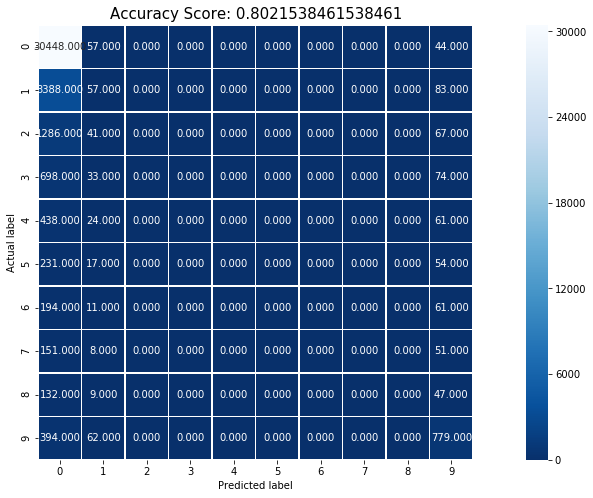

In [101]:
tree_predict = tree.predict(x_test)
tree_score = tree.score(x_test, y_test)
cm = confusion_matrix(y_test, tree_predict)
    
plt.figure(figsize=(global_width + 5, global_height))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(tree_score)
plt.title(all_sample_title, size = 15);

***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***

The confusion matrix really gets to the heart of the matter.

The model only correctly predicts these possible values:

- 1
- 2
- 10

Even as a binned value of a variable with high and low extremes, it still suffers from similar problems as trying to predict view_count did. It can predict 1s reliably well, it can predict 10s reliably well, but everything else is likely to be a failure.

***

### -> main_tag

Is it possible to predict the main_tag of a post? The majority of the time this will be the programming language that the question is referencing.

In [18]:
df['main_tag'] = df['main_tag'].astype(str)

# I mostly don't want to deal with id's / any categorical value with too many unique values
# Dropping main_tag_code bc that'd be cheating
cols_to_drop = ['id', 'last_editor_user_id', 'owner_user_id', 'post_type_id',
               'tags', 'title', 'body', 'last_activity_date', 'last_edit_date',
               'creation_date']
y_pro, df_pro = preprocess_data(df.drop(cols_to_drop, axis = 1), 'main_tag')

x_train, x_test, y_train, y_test = train_test_split(df_pro,
                                                    y_pro,
                                                    test_size=0.20,
                                                    random_state = random.randint(0,100))

tree = DecisionTreeClassifier(max_depth=15)
tree.fit(x_train, y_train)
tree.score(x_test,y_test)

0.7960580756789287

In [19]:
df['main_tag'] = df['main_tag'].astype(str)

# I mostly don't want to deal with id's / any categorical value with too many unique values
# Dropping main_tag_code bc that'd be cheating
cols_to_drop = ['id', 'last_editor_user_id', 'owner_user_id', 'post_type_id',
               'tags', 'title', 'body', 'last_activity_date', 'last_edit_date',
               'creation_date']
y_pro, df_pro = preprocess_data(df.drop(cols_to_drop, axis = 1), 'main_tag')

x_train, x_test, y_train, y_test = train_test_split(df_pro,
                                                    y_pro,
                                                    test_size=0.20,
                                                    random_state = random.randint(0,100))

In [20]:
tree = DecisionTreeClassifier(max_depth=10)
tree.fit(x_train, y_train)
tree.score(x_test,y_test)

0.801907914297894

In [21]:
a = np.array(['python' for _ in range(len(y_train))])
print('baseline zeros accuracy: ', accuracy_score(y_train, a))

baseline zeros accuracy:  0.8031926993310108


In [22]:
scores = cross_val_score(tree, x_train, y_train, cv=10)
print("Decision Tree model accuracy on main_tag: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Decision Tree model accuracy on main_tag: 0.80 (+/- 0.00)


A Decision Tree does a really strong job of predicting the main_tag! The cross_val_score also gives us some confidence that it's not just overfitting the test data as well

***

# Insights into the Data

In [23]:
# Sample size to practice with, only 30,000 cases
df_sample = df.sample(30000,
                      random_state = 1)

Now that we have the data into a shape that's:
- Organized
- Feature Engineered
- Much larger than the original 5,000 sample

We are ready to ask questions about it.

As someone who is more used to coding in R, I found a package, **dfply**, that allows me to explore data in a similar way, the upcoming code blocks do this for me

In [36]:
# Getting a dataframe of the most popular tags, along with what percent of users put code in their question
code_tags = (df >>
 filter_by(X.creation_year < 2019) >>
 select(X.main_tag, X.code, X.score, X.view_count,
       X.answer_count, X.comment_count, X.favorite_count) >>
 group_by(X.main_tag) >>
 summarize(sum_comment = X.comment_count.sum(),
           sum_answer = X.answer_count.sum(),
           sum_fave = X.favorite_count.sum(),
           sum_view = X.view_count.sum(),
           sum_score = X.score.sum(),
           code = X.code.sum(),
           n = n(X.main_tag)) >>
 mutate(code_percent = X.code / X.n) >>
 ungroup() >>
 arrange(X.n, X.code_percent, X.code, ascending = False)
)

code_tags.head(10)

,main_tag,sum_comment,sum_answer,sum_fave,sum_view,sum_score,code,n,code_percent
1689,javascript,44031,31855,12829.0,52202314,42107,16864,19553,0.862476
1673,java,38254,28320,10301.0,47821862,33393,13329,16561,0.804843
467,c#,33206,23679,7600.0,34823130,28585,11093,13899,0.798115
2484,php,32178,20898,4756.0,22097104,14389,10683,12629,0.845910
2635,python,24294,17981,7751.0,26673281,25859,10395,11826,0.878995
118,android,18895,15124,7776.0,25876823,22377,7061,10266,0.687804
470,c++,21134,11865,6230.0,15912330,20179,5327,6394,0.833125
1627,ios,12002,9224,4008.0,10142337,11723,4230,6198,0.682478
1752,jquery,7360,6455,1306.0,8699185,4780,3353,3917,0.856012
1484,html,7102,6694,2148.0,11056590,7210,2976,3585,0.830126


**code_tags** is an organized DataFrame of each of the main_tags, which for the most part will represent different languages people program in, with some good Data

Here we can see that Javascript, Java, and C# are the top three most popular tags within this dataset

In [37]:
(code_tags >>
    filter_by(X.n > 2000) >>
    arrange(X.code_percent, ascending = False))

,main_tag,sum_comment,sum_answer,sum_fave,sum_view,sum_score,code,n,code_percent
2671,r,5833,3733,1453.0,3890723,5009,2687,2920,0.920205
2635,python,24294,17981,7751.0,26673281,25859,10395,11826,0.878995
466,c,10529,5686,1562.0,6657563,5487,2452,2837,0.864293
1689,javascript,44031,31855,12829.0,52202314,42107,16864,19553,0.862476
1752,jquery,7360,6455,1306.0,8699185,4780,3353,3917,0.856012
3122,sql,8083,6615,1748.0,10083989,5956,2881,3398,0.847852
2484,php,32178,20898,4756.0,22097104,14389,10683,12629,0.845910
2833,ruby-on-rails,4608,4508,1756.0,3976489,5867,2562,3052,0.839450
470,c++,21134,11865,6230.0,15912330,20179,5327,6394,0.833125
1484,html,7102,6694,2148.0,11056590,7210,2976,3585,0.830126


R and Python are the two languages that are most likely to provide code with their post, which is good for us as Data Scientists

We can look at how languages change overtime as well, how their popularity grows and shifts. Speaking of Python and R, let's see how they have grown and changed overtime, and what their popularity as languages looks like

In [26]:
# This determines the tags that you're looking for!
tags_filter = ['python']

# Popular tags over time
tag_time = (df[df.main_tag.isin(tags_filter)] >>
 # This group_by determines the level of granularity. You could add X.creation_day, or even X.creation_hour to get a more
 # detailed graph
 group_by(X.creation_year, X.creation_month) >>
 summarize(main_tag = first(X.main_tag),
           n = n(X.main_tag))
)

tag_time['date'] = tag_time.creation_year.astype('str') + '-' + tag_time.creation_month.astype('str') + '-01'
tag_time['date'] = pd.to_datetime(tag_time['date'])
tag_time.index = tag_time.date

tag_p = tag_time.copy()
# The last one seems to always be smaller than the rest, taking it away helps the visualization
tag_p = tag_p[:-1]

# This determines the tags that you're looking for!
tags_filter = ['r']

# Popular tags over time
tag_time = (df[df.main_tag.isin(tags_filter)] >>
 #select(X.main_tag, X.creation_date) >>
 group_by(X.creation_year, X.creation_month) >>
 summarize(main_tag = first(X.main_tag),
           n = n(X.main_tag))
)

tag_time['date'] = tag_time.creation_year.astype('str') + '-' + tag_time.creation_month.astype('str') + '-01'
tag_time['date'] = pd.to_datetime(tag_time['date'])
tag_time.index = tag_time.date

tag_r = tag_time.copy()
tag_r = tag_r[:-1]

***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***
***

In [27]:
p_y = tag_p.copy()
r_y = tag_r.copy()

# The number of 'seasons' indicates how many ups and downs there are
# I also used it as a time indicator
seasons = 30
assert(seasons < len(tag_time))

p_fit = sm.tsa.ExponentialSmoothing(np.asarray(tag_p['n']),
                                   seasonal_periods= seasons,
                                   trend='add',
                                   seasonal='add',).fit()
r_fit = sm.tsa.ExponentialSmoothing(np.asarray(tag_r['n']),
                                   seasonal_periods= seasons,
                                   trend='add',
                                   seasonal='add',).fit()
p_y['Holt_Winter'] = p_fit.forecast(len(tag_p))
r_y['Holt_Winter'] = r_fit.forecast(len(tag_r))

days = p_y.index[len(p_y) - 1] - p_y.index[0]
p_y.index = p_y.date + days
days = r_y.index[len(r_y) - 1] - r_y.index[0]
r_y.index = r_y.date + days

p_y = p_y[0:seasons]
r_y = r_y[0:seasons]

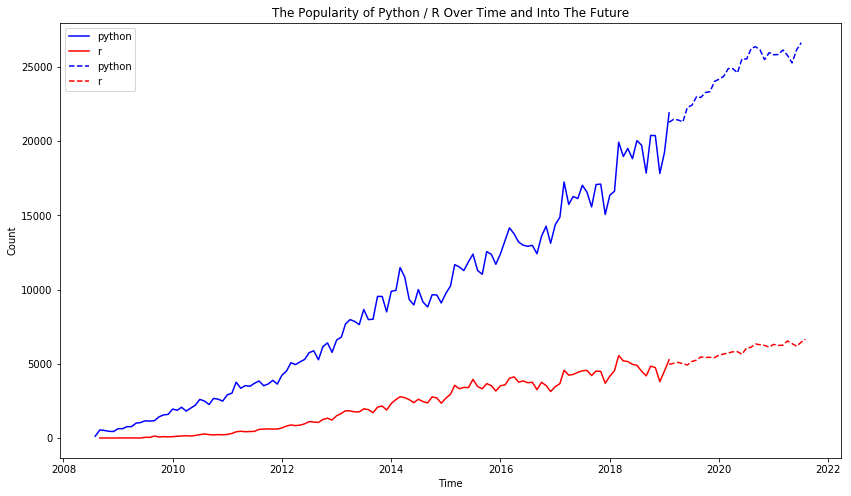

In [28]:
plt.figure(figsize=(global_width,global_height))
plt.plot( tag_p.n, label='python', color = 'blue')
plt.plot( tag_r.n, label='r', color = 'red')
plt.plot(p_y['Holt_Winter'], color = 'blue', linestyle='dashed', label = 'python')
plt.plot(r_y['Holt_Winter'], color = 'red', linestyle='dashed', label = 'r')

plt.xlabel('Time')
plt.ylabel('Count')
plt.title('The Popularity of Python / R Over Time and Into The Future')

plt.legend(loc='best')
plt.show()

Both languages are definitely growing!

At-least within the stackoverflow dataset Python is growing more quickly than R and looks to continue that trend.

<h1><center>Questions?</center></h1>